## Train multi-classification model with custom generator

In [1]:
import sys
sys.path.append('/home/zhay/DEEP/python/')
sys.path.append('/home/zhay/DEEP/python/lib/')
sys.path.append('/home/zhay/DEEP/python/machineLearning/')

import scipy as sp
import pandas as pd
import numpy as np
import pickle
from time import time
import matplotlib.pyplot as plt
from scipy import signal
from StickSlipDetector import StickSlipDetector
from keras.models import Model,load_model, save_model
from keras.layers import Input,LSTM,Dense,Conv1D,MaxPooling1D,Dropout,BatchNormalization,Flatten
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.layers import merge,concatenate
import keras
from keras_utility import precision, recall, binary_xentropy, fmeasure, augmentData,cut_to_batch
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.utils import np_utils
from keras.optimizers import Adam
from IPython.display import SVG

import deep_util
import modeldef
from imp import reload
reload(deep_util)
reload(modeldef)
%matplotlib notebook

ImportError: No module named 'keras'

### Set processing parameters

In [196]:
trainingFileList=['/home/zhay/DEEP/machineLearning/vibrationDetector/data/timeseries_30s_8channel_RR30.p',
#               '/home/zhay/DEEP/machineLearning/vibrationDetector/data/timeseries_30s_8channel_RR31.p',
              '/home/zhay/DEEP/machineLearning/vibrationDetector/data/timeseries_30s_8channel_RR32.p',
              '/home/zhay/DEEP/machineLearning/vibrationDetector/data/timeseries_30s_8channel_RR34.p',
              '/home/zhay/DEEP/machineLearning/vibrationDetector/data/timeseries_30s_8channel_RR35.p'
             ]

testFileList=['/home/zhay/DEEP/machineLearning/vibrationDetector/data/timeseries_30s_8channel_RR31.p',
#               '/home/zhay/DEEP/machineLearning/vibrationDetector/data/timeseries_30s_8channel_RR31.p',
#               '/home/zhay/DEEP/machineLearning/vibrationDetector/data/timeseries_60s_6channel_RR32.p',
#               '/home/zhay/DEEP/machineLearning/vibrationDetector/data/timeseries_60s_6channel_RR34.p',
#               '/home/zhay/DEEP/machineLearning/vibrationDetector/data/timeseries_60s_6channel_RR35.p'
             ]
# parameters to generate spectrogram
nfft=1024
nfftOverlap=nfft*0.9

# sampling rate of data
fs=100
dt=1/fs

# maximum frequency to look at 
freqMax=20

batchSize=128
conditionList=[['01_Global-Generic_Surface-copRigState',0,100],['01_Global-Generic_Surface-SRPM',50,1000],
#                ['01_Global-Generic_Surface-BIT_DEPTH', 8500/3.28,12500/3.28]
              ]
fg = deep_util.FeatureGenerator()
fg.setParam(nfft=nfft,nfftOverlap=nfftOverlap,freqMax=freqMax,batchSize=batchSize,conditionList=conditionList)

X_train,Y_train,auxDataDict_train=fg.GenerateFeatures(trainingFileList,conditionList,ytype='mean',cutToBatch=True)
X_test,Y_test,auxDataDict_test=fg.GenerateFeatures(testFileList,conditionList,ytype='mean',cutToBatch=True)


Reading file /home/zhay/DEEP/machineLearning/vibrationDetector/data/timeseries_30s_8channel_RR30.p
reading 19532.000000 samples
Reading file /home/zhay/DEEP/machineLearning/vibrationDetector/data/timeseries_30s_8channel_RR32.p
reading 13200.000000 samples
Reading file /home/zhay/DEEP/machineLearning/vibrationDetector/data/timeseries_30s_8channel_RR34.p
reading 16624.000000 samples
Reading file /home/zhay/DEEP/machineLearning/vibrationDetector/data/timeseries_30s_8channel_RR35.p
reading 22254.000000 samples
Size of merged data X is: 
number of samples
71610
Shape of X (nsample,nt,nchannel):
(71610, 3000, 8)
 0 percent finished
10 percent finished
20 percent finished
30 percent finished
40 percent finished
50 percent finished
60 percent finished
70 percent finished
80 percent finished
90 percent finished
Reading file /home/zhay/DEEP/machineLearning/vibrationDetector/data/timeseries_30s_8channel_RR31.p
reading 26738.000000 samples
Size of merged data X is: 
number of samples
26738
Shape o

In [197]:
auxDataDict_train

{'01_Global-Generic_Surface-BIT_DEPTH': array([ 1525.2034,  1525.851 ,  1526.4298, ...,  5273.8602,  5274.2373,
         5274.6826]),
 '01_Global-Generic_Surface-SRPM': array([ 59.982464,  59.81101 ,  60.096775, ...,  79.21458 ,  80.50053 ,
         80.27191 ]),
 '01_Global-Generic_Surface-SWOB': array([ 150821.26 ,  149696.3  ,  153279.44 , ...,  170719.93 ,
         176154.055,  180702.08 ]),
 '01_Global-Generic_Surface-copROP': array([ 66.381782,  73.13737 ,  75.72695 , ...,  46.378368,  48.4632  ,
         51.499008]),
 '01_Global-Generic_Surface-copRigState': array([ 0.,  0.,  0., ...,  0.,  0.,  0.])}

In [198]:
Xt_train,Xs_train=X_train
Yt_train,Ys_train=Y_train

Xt_test,Xs_test=X_test
Yt_test,Ys_test=Y_test
print('training data shape')
print(Xt_train.shape)
print(Xs_train.shape)

print('test data shape')
print(Xt_test.shape)
print(Xs_test.shape)

# scaler.fit?

training data shape
(21888, 3000, 8, 1)
(21888, 20, 205, 8)
test data shape
(6528, 3000, 8, 1)
(6528, 20, 205, 8)


In [199]:
nsample_train=Xt_train.shape[0]
nsample_test=Xt_test.shape[0]

metaData_train=np.zeros((nsample_train,3))
metaData_train[:,0] = auxDataDict_train['01_Global-Generic_Surface-SRPM']
metaData_train[:,1] = auxDataDict_train['01_Global-Generic_Surface-SWOB']
metaData_train[:,2] = auxDataDict_train['01_Global-Generic_Surface-copROP']

metaData_test=np.zeros((nsample_test,3))
metaData_test[:,0] = auxDataDict_test['01_Global-Generic_Surface-SRPM']
metaData_test[:,1] = auxDataDict_test['01_Global-Generic_Surface-SWOB']
metaData_test[:,2] = auxDataDict_test['01_Global-Generic_Surface-copROP']
# metaData_train=np.zeros(nsample_train,3)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler=scaler.fit(metaData_train)
metaData_train_norm = scaler.transform(metaData_train)
metaData_test_norm = scaler.transform(metaData_test)


### Convert continuous target to class


In [428]:
lowLimit=3
highLimit=5

# training data
Y_catagory_train = np.zeros((Ys_train.shape))
Y_catagory_train[Ys_train<lowLimit]=0
Y_catagory_train[(Ys_train<highLimit) & (Ys_train >=lowLimit)]=1
Y_catagory_train[Ys_train >=highLimit]=2
Y_catagory_train_onehot=keras.utils.to_categorical(Y_catagory_train)

# test data
Y_catagory_test = np.zeros((Ys_test.shape))
Y_catagory_test[Ys_test<lowLimit]=0
Y_catagory_test[(Ys_test<highLimit) & (Ys_test >=lowLimit)]=1
Y_catagory_test[Ys_test >=highLimit]=2
Y_catagory_test_onehot=keras.utils.to_categorical(Y_catagory_test)
print('relative fraction of classes are: weak/moderage/strong')
print(np.sum(Y_catagory_train_onehot,axis=(0,1))/np.sum(Y_catagory_train_onehot))

relative fraction of classes are: weak/moderage/strong
[ 0.88989857  0.08832237  0.02177906]


<IPython.core.display.Javascript object>


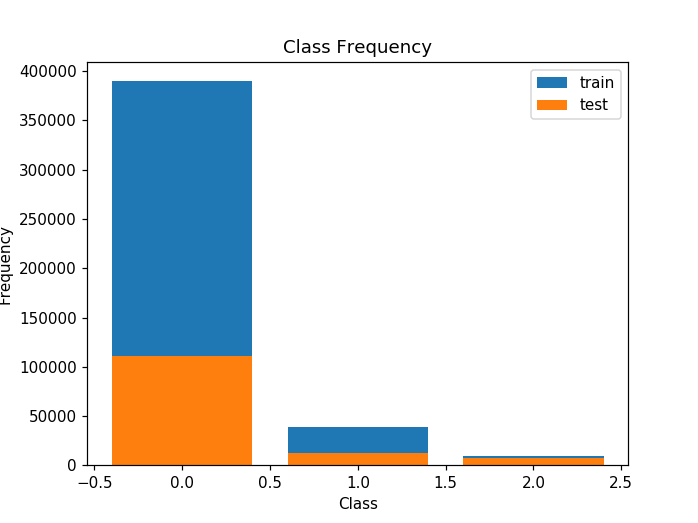

In [429]:
plt.figure()

unique, counts = np.unique(Y_catagory_train, return_counts=True)
plt.bar(unique, counts,label='train')
unique, counts = np.unique(Y_catagory_test, return_counts=True)
plt.bar(unique, counts,label='test')

plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.legend()
plt.show()



### Plot random example data and target 

<IPython.core.display.Javascript object>


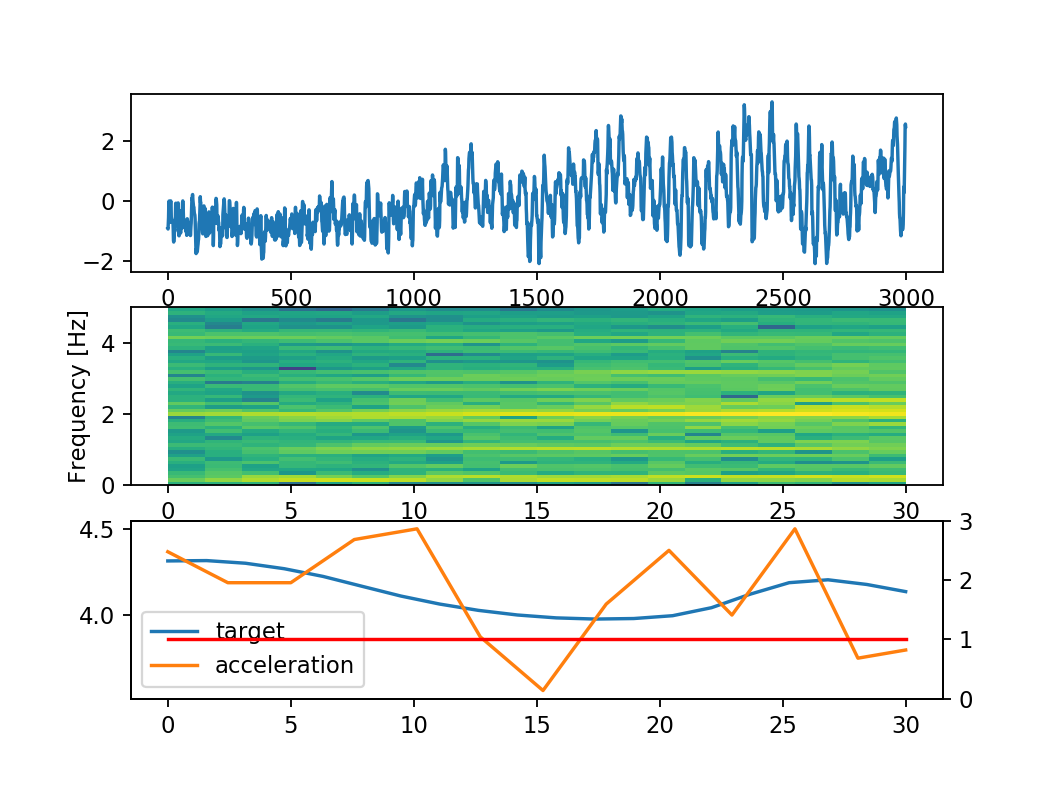

In [430]:
ntSpec,nf,nc=X_train[1][0].shape
ntSample,nc,_=X_train[0][0].shape
ichannel=0
# Plot random sample
# select data where y has a positive hit
idx_stick=np.where(np.max(Y_train[1],axis=1)>4)[0]
# idx=np.random.randint(0,nsample)
idx=np.random.choice(idx_stick)

# plt.plot(X_time[m,:,1])
# plt.plot(X_time[m,:,3])

Xs_sample=X_train[1][idx,:,:,ichannel]
Xt_sample=X_train[0][idx,:,ichannel]

# Y_sample=Y_select[ind_strong][idx]
Ys_sample=Y_train[1][idx]
Yt_sample=Y_train[0][idx]

Y_class_sample = Y_catagory_train[idx]

# ------------------------

vf=np.linspace(0,freqMax,nf)
vt=np.linspace(0,ntSample*dt,ntSpec)
vt2=np.linspace(0,ntSample*dt,Xt_sample.shape[0])

plt.figure(dpi=150)
ax1=plt.subplot(311)
plt.plot(Xt_sample)

ax2=plt.subplot(312)
extents = vt[0], vt[-1],vf[0],vf[-1]

plt.imshow(10*np.log10(np.transpose(Xs_sample)),aspect='auto',origin='lower',extent=extents)
# plt.imshow(Xs_sample,aspect='auto',origin='lower',extent=extents)

plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
# plt.clim(40,80)
plt.ylim(0,5)

ax3=plt.subplot(313,sharex=ax2)
plt.plot(vt,Ys_sample,label='target')
plt.plot(vt2,Yt_sample,label='acceleration')

ax3b=ax3.twinx()
plt.plot(vt,Y_class_sample,'-r',label=' class label')
plt.ylim([0,3])
# ax3b.legend()
ax3.legend()
# plt.suptitle(trainingDict['inputChannel'][ichannel])
plt.show()



In [251]:
from keras.layers import ZeroPadding2D,ZeroPadding1D
from keras.models import Sequential,Model,Input
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.core import Reshape, Permute
from keras.layers import Merge,concatenate,RepeatVector
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import TimeDistributed
def model_branched_cnn_mixed_lstm_classification_padding_meta(input1Shape, input2Shape, input3Shape,outputShape, numFilter=4, numUnitLSTM=16,batchSize=None,
                                                    stateful=False,
                                                    dropout=0):
    """model with mixed sampling rate and type
    input 1: (nsample, nt,nchannel,1) for time series
    input 2: (nsample, nt,nfreq,nchannel) for spectrogram
    """
    optimizer = 'adam'
    loss = 'categorical_crossentropy'
    kernelSize1 = (3, 3)
    kernelSize2 = (2, 5)
    
    ntOut = outputShape[0]
    nclassOut=outputShape[1]
    
    input1 = Input(batch_shape=(batchSize,) + input1Shape,name='timeseries')
    input2 = Input(batch_shape=(batchSize,) + input2Shape,name='spectrogram')
    aux_input = Input(batch_shape=(batchSize,) + input3Shape,name='auxdata')


    # -------------branch 1 : time series -----------------
    branch1 = Sequential()
    branch1.add(Convolution2D(numFilter, kernelSize1, padding='same', batch_input_shape=(batchSize,) + input1Shape))
    branch1.add(MaxPooling2D(pool_size=(2, 1)))
    branch1.add(Activation('relu'))

    branch1.add(Dropout(dropout))

    branch1.add(Convolution2D(numFilter, kernelSize1, padding='same'))
    branch1.add(MaxPooling2D(pool_size=(2, 1)))
    branch1.add(Activation('relu'))
    branch1.add(Dropout(dropout))

    branch1.add(Convolution2D(numFilter, kernelSize1, padding='same'))
    branch1.add(MaxPooling2D(pool_size=(2, 1)))
    branch1.add(Activation('relu'))
    #     reshape branch 1 input to match output time step: from (ntConv,nc,nfilter) to (ntOut,ntConv//ntConv*nc*nfilter)
    convOutShape1 = branch1.layers[-1].output_shape 
    branch1.add(Reshape((convOutShape1[1], np.prod(convOutShape1[2:4]))))
#     integer multiple of output shape

    nPadTo = int(np.ceil(convOutShape1[1]/ntOut)*ntOut)
    nPadding=(nPadTo-convOutShape1[1])
    branch1.add(ZeroPadding1D(padding=(0,nPadding)))
    print('original size: ')
    print(convOutShape1[1])
    print('padding to multiples of:')
    print(ntOut)
    
    print('new shape: ')
    print(branch1.layers[-1].output_shape)
    branch1.add(Reshape((ntOut, -1)))
    branch1.add(Dropout(dropout))

    # -------------branch 2 : spectrogram -----------------
    branch2 = Sequential()
    branch2.add(Convolution2D(numFilter, kernelSize2, padding='same', batch_input_shape=(batchSize,) + input2Shape))
    branch2.add(MaxPooling2D(pool_size=(1, 2)))
    branch2.add(Activation('relu'))
    branch2.add(Dropout(dropout))
    branch2.add(Convolution2D(numFilter, kernelSize2, padding='same'))
    branch2.add(MaxPooling2D(pool_size=(1, 2)))
    branch2.add(Activation('relu'))
    convOutShape2 = branch2.layers[-1].output_shape
    branch2.add(Reshape((convOutShape2[1], np.prod(convOutShape2[2:4]))))

    branch2.add(Dropout(dropout))
    output1 = branch1(input1)
    output2 = branch2(input2)

    #     model = Sequential()

    # -------------merge branch 1 with branch 2 -----------------
    #     model.add(keras.layers.merge.concatenate([branch1, branch2], mode='concat', concat_axis=2))
    #     model.add(concatenate([branch1,branch2],axis=2))
    mergedInput = concatenate([output1, output2], axis=2)

    #     keras.layers.concatenate
    #     convOutShape = model.layers[-1].output_shape
    #     model.add(Reshape((np.prod(convOutShape[1:3]), convOutShape[3])))
    #     model.add(Permute((2, 1)))
    #     model.add(LSTM(48, return_sequences=True, stateful=True))
    X = LSTM(numUnitLSTM, return_sequences=True, stateful=stateful)(mergedInput)
    X=Dropout(dropout)(X)
    #     model.add(LSTM(48, return_sequences=True))
    X = LSTM(numUnitLSTM, return_sequences=True)(X)
    X=Dropout(dropout)(X)

    #     model.add(TimeDistributed(Dense(1)))
#     -----------------aux input-------------------
    aux_input_repeat=RepeatVector(ntOut)(aux_input)
    X_merge_aux = concatenate([X, aux_input_repeat])
    
    output = TimeDistributed(Dense(nclassOut,activation='softmax'))(X_merge_aux)
#     model.add(Activation('softmax'))

    model = Model(inputs=[input1, input2,aux_input], outputs=output)

    return model, optimizer, loss

In [431]:
# Define custom metrics
from keras import backend as K

def r2_score(y_data,y_pred):
    ss_tot=np.sum((y_data-np.mean(y_data))**2)
    ss_res=np.sum((y_data-y_pred)**2)
    r2=1-ss_res/ss_tot
    return r2


def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [432]:
def BalancedDataGenerator(features, labels, batch_size):
#     np.sum(labels,axis=(0,1))/np.sum(labels)
    feature1,feature2,feature3 = features
    while True:
        batch_feature1=np.zeros((batchSize,)+feature1.shape[1:])
        batch_feature2=np.zeros((batchSize,)+feature2.shape[1:])
        batch_feature3=np.zeros((batchSize,)+feature3.shape[1:])
        batch_labels=np.zeros((batchSize,)+labels.shape[1:])
        for i in range(batch_size):
            index = np.random.choice(len(features),1)
            batch_feature1[i]=feature1[index]
            batch_feature2[i]=feature2[index]
            batch_feature3[i]=feature3[index]
            batch_labels[i]=labels[index]
            
        yield [batch_feature1,batch_feature2,batch_feature3],batch_labels


<IPython.core.display.Javascript object>


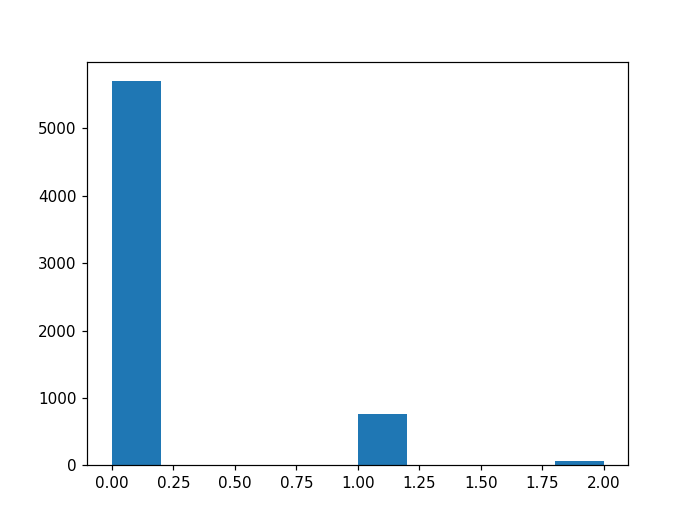

(array([ 5694.,     0.,     0.,     0.,     0.,   768.,     0.,     0.,
            0.,    66.]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ]),
 <a list of 10 Patch objects>)

In [433]:
maxClass=np.max(np.argmax(Target_test,axis=2),axis=1)
plt.figure()
plt.hist(maxClass)


In [131]:
a=[1,2,3]
np.random.choice(a,1,p=(1/3,1/3,1/3))
np.arange(3)

array([0, 1, 2])

In [434]:
maxClass=np.max(np.argmax(Target_test,axis=2),axis=1)
maxClass
classPropability=[1,1,1]
nclass=len(classPropability)
idx_list=[]
prob = [p/sum(classPropability) for p in classPropability]
for i in range(nclass):
    idx_list.append(np.where(maxClass==i)[0])
iclass=np.random.choice(np.arange(nclass),p=prob)
iclass
# index = np.random.choice(idx_list[iclass],1)


1

In [435]:
# A function to return batches with ramdom samples from each class with certain weights

def BalancedDataGenerator_weighted(features, labels, batch_size,classPropability=[1,1,1]):
#     np.sum(labels,axis=(0,1))/np.sum(labels)
    feature1,feature2,feature3 = features
    
    #   maximum catagory for this sample
    maxClass=np.max(np.argmax(labels,axis=2),axis=1)
    nclass=len(classPropability)
    idx_list=[]
    prob = [p/sum(classPropability) for p in classPropability]
#     list of index corresponding to each class
    for i in range(nclass):
        idx_list.append(np.where(maxClass==i)[0])
    
    while True:
        batch_feature1=np.zeros((batchSize,)+feature1.shape[1:])
        batch_feature2=np.zeros((batchSize,)+feature2.shape[1:])
        batch_feature3=np.zeros((batchSize,)+feature3.shape[1:])
        batch_labels=np.zeros((batchSize,)+labels.shape[1:])
        
        for i in range(batch_size):
#           randomly select class with probabilility
            iclass=np.random.choice(np.arange(nclass),p=prob)         
    
#           ramdonly select a sample within a certain class
            index = np.random.choice(idx_list[iclass],1)

            batch_feature1[i]=feature1[index]
            batch_feature2[i]=feature2[index]
            batch_feature3[i]=feature3[index]
            batch_labels[i]=labels[index]
            
        yield [batch_feature1,batch_feature2,batch_feature3],batch_labels

### Build and train model

In [437]:
from modeldef import model_branched_cnn_mixed_lstm_regression_functional
# from modeldef import model_branched_cnn_mixed_lstm_regression_padding
nt,nf,nc=X_train[0][0].shape
inputShape1=X_train[0].shape[1:]
inputShape2=X_train[1].shape[1:]
inputShape3=metaData_train_norm.shape[1:]

# inputShape2=(20, 205, 8)
# outputShape=Y_train[1].shape[1:]
outputShape=Y_catagory_train_onehot.shape[1:]

# outputShape=(20,1)
# batchSize=32

numFilter=[4]
nUnitLSTM=[8,16,32]
dropoutRate=[0.1,0.3]


modelList=[]
historyList=[]
scoreList=[]

Feature_train=[X_train[0],X_train[1],metaData_train_norm]
Feature_test=[X_test[0],X_test[1],metaData_test_norm]


Target_train=Y_catagory_train_onehot
Target_test=Y_catagory_test_onehot
nsample_train=Y_catagory_train_onehot.shape[0]
nsample_test=Y_catagory_test_onehot.shape[0]
# X_train=[Xt_train,Xs_train]
# X_test=[Xt_test,Xs_test]

# for nf in numFilter:
ParamList=[[a,b] for a in nUnitLSTM for b in dropoutRate ]

# for nlstm in nUnitLSTM:
for nlstm, dropOutRate in ParamList:
    print('----------LSTM UNIT = %3f------------'%nlstm)
    print('----------dropOut Rate = %1.2f------------'%dropOutRate)
    model, optimizer, loss=model_branched_cnn_mixed_lstm_classification_padding_meta(
                                                                input1Shape=inputShape1, input2Shape=inputShape2,
                                                                input3Shape=inputShape3,
                                                                outputShape=outputShape,stateful=False,
                                                                numFilter=numFilter[0], numUnitLSTM=nlstm, batchSize=batchSize,
                                                                dropout=dropOutRate)
#     model, optimizer, loss=model_branched_cnn_mixed_lstm_regression_functional(
#                                                                 input1Shape=inputShape1, input2Shape=inputShape2, 
#                                                                 outputShape=outputShape,stateful=False,
#                                                                 numFilter=nf, batchSize=batchSize,dropout=0.5)
    model.compile(loss=loss,optimizer=optimizer,metrics=['accuracy',precision,recall])
#     model.compile(loss='mae',optimizer=optimizer,metrics=['mse',r2_keras])

    earlyStop=keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0.0,
                              patience=5,
                              verbose=0, mode='auto')
    model.summary()

    print('size of first branch training data: ' + str(Feature_train[0].shape))
    print('size of second branch training data: ' + str(Feature_train[1].shape))

#     class_weight={0:1,1:2,2:5}
#     History=model.fit(Feature_train, Target_train,
#                   batch_size=batchSize, 
#                   epochs=30,
#                   validation_data=(Feature_test,Target_test),
#                   callbacks=[earlyStop],
#                   shuffle=True,verbose=1)
#     generator_train=BalancedDataGenerator(features=Feature_train,labels=Target_train,batch_size=batchSize)
    generator_train=BalancedDataGenerator_weighted(features=Feature_train,labels=Target_train,
                                                   batch_size=batchSize,classPropability=[1,1,1])

#     generator_test=BalancedDataGenerator_weighted(features=Feature_test,labels=Target_test,
#                                                    batch_size=batchSize,classPropability=[1,1,1])
        
    History=model.fit_generator(generator_train,
                                epochs=30,
                                steps_per_epoch=int(nsample_train/batchSize),
                                validation_data=(Feature_test,Target_test),
#                                 validation_data=generator_test,
#                                 validation_steps=int(nsample_test/batchSize),
                                callbacks=[earlyStop],
                                shuffle=True,verbose=1)
#     Y_predict_train=model.predict(Feature_train,verbose=1)
#     Y_predict_test=model.predict(Feature_test,verbose=1)
    
#     r2_train=r2Coeff(np.max(Ys_train,axis=1),np.max(Y_predict_train,axis=1))
#     r2_test=r2Coeff(np.max(Ys_test,axis=1),np.max(Y_predict_test,axis=1))    
    
    score=model.evaluate(Feature_test,Target_test,batch_size=batchSize)
#     score.append(r2_train)
#     score.append(r2_test)
    
# ssd.setModelParameters(lr=0.001,strides=4,poolingSize=4,nfilter=nfilter,filterLength=filterLength,patience=10)
# model=multiChannelTimeSeriesModel(input_shape=(nc,nt),nUnitRNN=16,numClasses=2)
# model, optimizer, loss=modeldef.model_cnn_lstm_adam_binary(inputShape=(nt,nf,nc), batchSize=batchSize)
# model, optimizer, loss=modeldef.model_cnn_lstm_adam_binary_dropout(inputShape=(nt,nf,nc), batchSize=batchSize,dropout=0.4)

# model, optimizer, loss=model_cnn_lstm_adam(inputShape=(nt,nf,nc), numClasses=1, batchSize=batchSize)
# model, optimizer, loss=model_cnn_lstm_adam_functional(inputShape=(nt,nf,nc), numClasses=1, batchSize=batchSize)
# branch1.summary()
# branch2.summary()
    modelList.append(model)
    historyList.append(History)
    scoreList.append(score)


----------LSTM UNIT = 8.000000------------
----------dropOut Rate = 0.10------------
original size: 
375
padding to multiples of:
20
new shape: 
(128, 380, 32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
timeseries (InputLayer)         (128, 3000, 8, 1)    0                                            
__________________________________________________________________________________________________
spectrogram (InputLayer)        (128, 20, 205, 8)    0                                            
__________________________________________________________________________________________________
sequential_125 (Sequential)     (128, 20, 608)       336         timeseries[0][0]                 
__________________________________________________________________________________________________
sequential_126 (Sequential)     (128, 20, 204)  

Epoch 1/30
171/171 [==============================] - 93s 546ms/step - loss: 1.1142 - acc: 0.4163 - precision: 0.4528 - recall: 0.2331 - val_loss: 1.0013 - val_acc: 0.5561 - val_precision: 0.6423 - val_recall: 0.3826
Epoch 2/30
171/171 [==============================] - 78s 458ms/step - loss: 0.9113 - acc: 0.5547 - precision: 0.6220 - recall: 0.3896 - val_loss: 0.8423 - val_acc: 0.6193 - val_precision: 0.7069 - val_recall: 0.4576
Epoch 3/30
171/171 [==============================] - 80s 466ms/step - loss: 0.8560 - acc: 0.5935 - precision: 0.6599 - recall: 0.4442 - val_loss: 0.7897 - val_acc: 0.6578 - val_precision: 0.7650 - val_recall: 0.4979
Epoch 4/30
171/171 [==============================] - 80s 465ms/step - loss: 0.8288 - acc: 0.6097 - precision: 0.6744 - recall: 0.4658 - val_loss: 0.8047 - val_acc: 0.6294 - val_precision: 0.7265 - val_recall: 0.4777
Epoch 5/30
171/171 [==============================] - 79s 464ms/step - loss: 0.8140 - acc: 0.6167 - precision: 0.6758 - recall: 0.48

171/171 [==============================] - 81s 472ms/step - loss: 0.6813 - acc: 0.6829 - precision: 0.7252 - recall: 0.6064 - val_loss: 0.6431 - val_acc: 0.7333 - val_precision: 0.7780 - val_recall: 0.6716
Epoch 14/30
171/171 [==============================] - 81s 472ms/step - loss: 0.6705 - acc: 0.6863 - precision: 0.7284 - recall: 0.6128 - val_loss: 0.6622 - val_acc: 0.7379 - val_precision: 0.7800 - val_recall: 0.6753
Epoch 15/30
6528/6528 [==============================] - 8s 1ms/step
----------LSTM UNIT = 32.000000------------
----------dropOut Rate = 0.10------------
original size: 
375
padding to multiples of:
20
new shape: 
(128, 380, 32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
timeseries (InputLayer)         (128, 3000, 8, 1)    0                                            
_________________________________________________

Epoch 1/30
171/171 [==============================] - 83s 483ms/step - loss: 0.9583 - acc: 0.5159 - precision: 0.6111 - recall: 0.2859 - val_loss: 0.7150 - val_acc: 0.7532 - val_precision: 0.8148 - val_recall: 0.6161
Epoch 2/30
171/171 [==============================] - 63s 370ms/step - loss: 0.8568 - acc: 0.5858 - precision: 0.6676 - recall: 0.4199 - val_loss: 0.7638 - val_acc: 0.7323 - val_precision: 0.7995 - val_recall: 0.5858
Epoch 3/30
171/171 [==============================] - 63s 370ms/step - loss: 0.8142 - acc: 0.6116 - precision: 0.6790 - recall: 0.4741 - val_loss: 0.6835 - val_acc: 0.7731 - val_precision: 0.8214 - val_recall: 0.6450
Epoch 4/30
171/171 [==============================] - 63s 370ms/step - loss: 0.7855 - acc: 0.6298 - precision: 0.6902 - recall: 0.5112 - val_loss: 0.6714 - val_acc: 0.7646 - val_precision: 0.8145 - val_recall: 0.6461
Epoch 5/30
171/171 [==============================] - 64s 372ms/step - loss: 0.7607 - acc: 0.6386 - precision: 0.6966 - recall: 0.52

In [377]:
scoreList

[[0.34061026339437445,
  0.87582720377865964,
  0.87912498151554785,
  0.87131587196798888],
 [0.41830631418555392,
  0.85304840581089847,
  0.8595760108209124,
  0.84396446160241667],
 [0.40811370853699891,
  0.85117953372936628,
  0.85431930189039196,
  0.84729625898249006],
 [0.42869476258170369,
  0.84595588492412188,
  0.84899653406704179,
  0.8422028200299132],
 [0.37506718225046698,
  0.87452512278276329,
  0.8764689301743227,
  0.87221200910269048],
 [0.39783505028953742,
  0.86765471802038308,
  0.86944991467045807,
  0.86434589589343347]]

In [258]:
for l in model.layers:
    print(l.name)
#     print(l.input_shape)
    print(l.output_shape)
model.layers[2].summary()
model.layers[3].summary()


timeseries
(128, 3000, 8, 1)
spectrogram
(128, 20, 205, 8)
sequential_99
(128, 20, 608)
sequential_100
(128, 20, 204)
concatenate_99
(128, 20, 812)
lstm_99
(128, 20, 32)
dropout_349
(128, 20, 32)
lstm_100
(128, 20, 32)
auxdata
(128, 3)
dropout_350
(128, 20, 32)
repeat_vector_50
(128, 20, 3)
concatenate_100
(128, 20, 35)
time_distributed_50
(128, 20, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_246 (Conv2D)          (128, 3000, 8, 4)         40        
_________________________________________________________________
max_pooling2d_246 (MaxPoolin (128, 1500, 8, 4)         0         
_________________________________________________________________
activation_246 (Activation)  (128, 1500, 8, 4)         0         
_________________________________________________________________
dropout_344 (Dropout)        (128, 1500, 8, 4)         0         
___________________________________________________

### Compile model

In [445]:
[score for score in scoreList]

[[0.65692410252842248,
  0.71192555334053786,
  0.73601570024209861,
  0.64929534436440939],
 [0.66854490339756012,
  0.7370634187085956,
  0.77505314130993452,
  0.68275888658621731],
 [0.64514241031571928,
  0.76080728979671708,
  0.77698573528551584,
  0.72820159442284527],
 [0.70112852518465008,
  0.71543351575440051,
  0.75953829989713784,
  0.65935202351972166],
 [0.8266351778133243,
  0.65249693335271353,
  0.67195545779723742,
  0.62811734176733913],
 [0.66355591837097616,
  0.7507812465522804,
  0.7691229418212292,
  0.72202052643486103]]

-2.5631571145935457

<IPython.core.display.Javascript object>


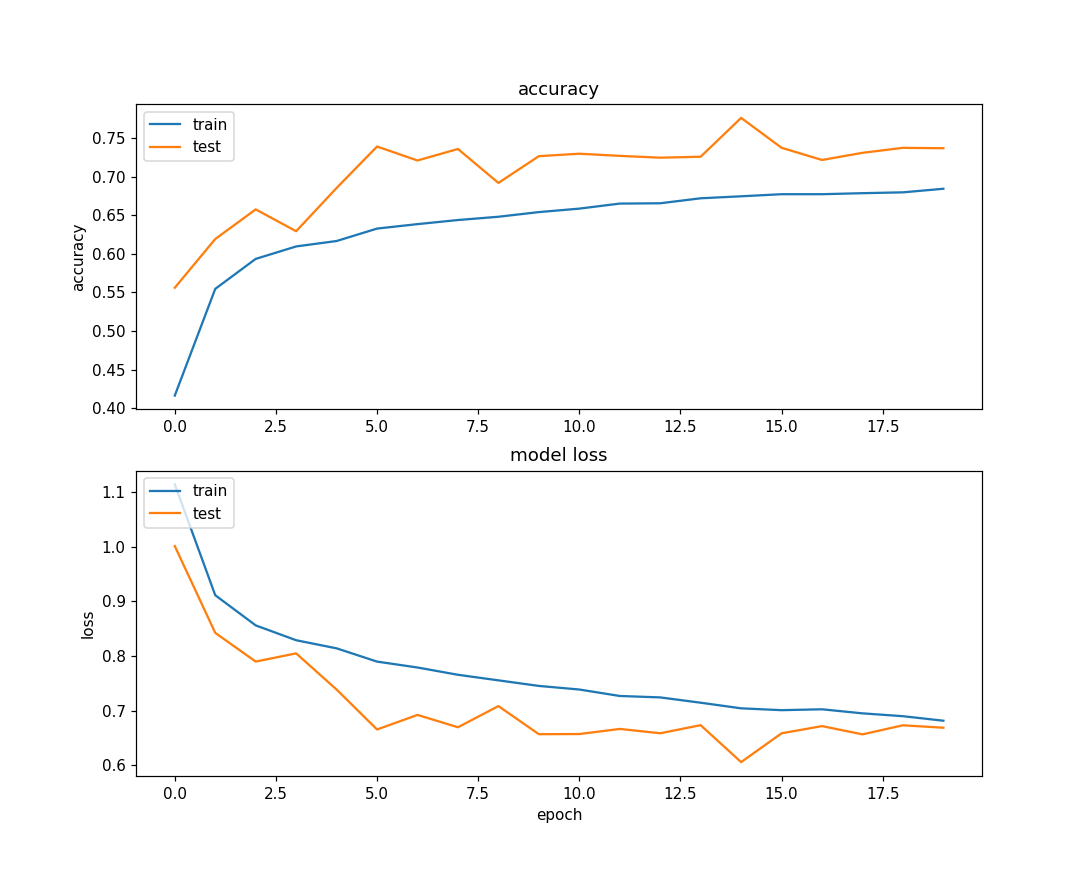

In [451]:
imodel=1
History=historyList[imodel]
model=modelList[imodel]
# Training history
fig=plt.figure(figsize=[10,8])
# fig.set_size_inches(12,10)
ax1=plt.subplot(211)
plt.plot(History.history['acc'])
plt.plot(History.history['val_acc'])
plt.title('accuracy')
plt.ylabel('accuracy')
#plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.show()

# fig=plt.figure(figsize=[12,10])


ax2=plt.subplot(212)
# summarize history for loss
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# Training history
# fig=plt.figure(figsize=[10,8])
# # fig.set_size_inches(12,10)
# ax1=plt.subplot(211)
# plt.plot(History.history['mean_squared_error'])
# plt.plot(History.history['val_mean_squared_error'])
# plt.title('model mean square error')
# plt.ylabel('mae')
# #plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# # plt.show()

# # fig=plt.figure(figsize=[12,10])


# ax2=plt.subplot(212)
# # summarize history for loss
# plt.plot(History.history['loss'])
# plt.plot(History.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [453]:
Y_prob_train = model.predict(Feature_train,verbose=1,batch_size=batchSize)
Y_predict_train=np.argmax(Y_prob_train,axis=2)
prob_strong_train = Y_prob_train[:,:,1]

Y_prob_test = model.predict(Feature_test,verbose=1,batch_size=batchSize)
Y_predict_test=np.argmax(Y_prob_test,axis=2)
prob_strong_test = Y_prob_test[:,:,1]

6528/6528 [==============================] - 6s 877us/step


In [454]:
# model=modelList[0]
# plot test example
Xs_plot=X_test[1]
Xt_plot=X_test[0]
Ys_plot=Y_test[1]
Yt_plot=Y_test[0]
Y_predict = Y_predict_test
Y_catagory_plot=Y_catagory_test

# plot training example
# Xs_plot=X_train[1]
# Xt_plot=X_train[0]
# Ys_plot=Y_train[1]
# Yt_plot=Y_train[0]
# Y_predict = Y_predict_train
# Y_catagory_plot=Y_catagory_train


# Y_predict=model.predict(X_plot,verbose=1)



<IPython.core.display.Javascript object>


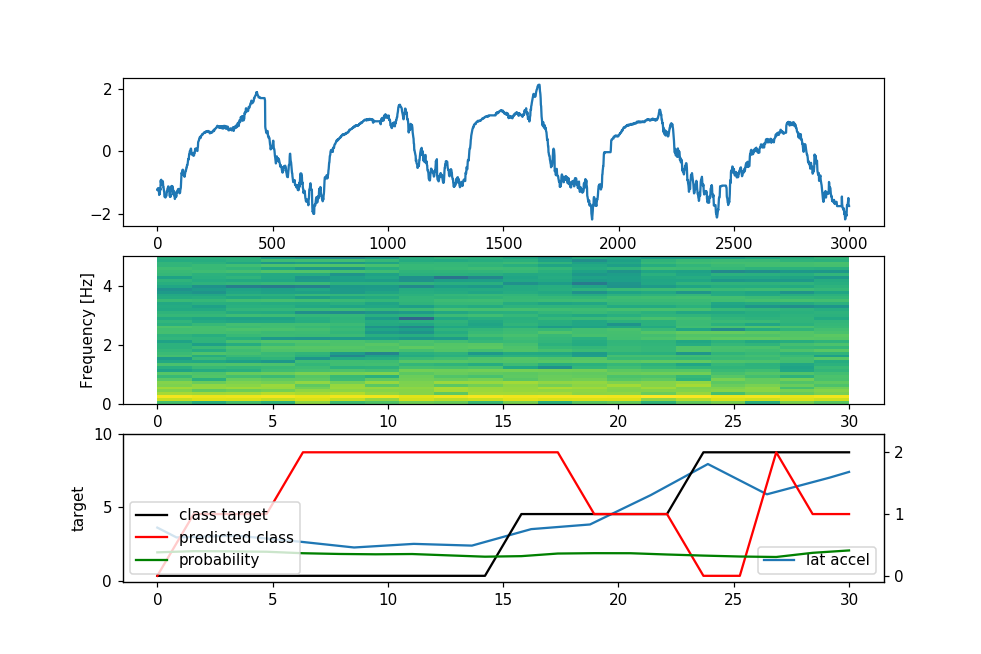

In [467]:
# Plot random sample
ichannel=0
nsample=Xs_plot.shape[0]
idx=np.random.randint(0,nsample)

# select from subset of samples containing positive labels
# select data where y has a positive hit
idx_stick=np.where(np.max(Ys_plot,axis=1)>4)[0]
# idx_stick=np.where((np.max(np.abs(Ys_plot-Y_predict),axis=1)<1) & (np.max(Ys_plot,axis=1)>2))[0]

# idx_stick=np.where(np.max(np.round(Y_predict),axis=1)>0)[0]

# idx=np.random.randint(0,nsample)
idx=np.random.choice(idx_stick)

Xs_sample=Xs_plot[idx,:,:,ichannel]
Xt_sample=Xt_plot[idx,:,ichannel]

Ys_sample=Ys_plot[idx]
Yt_sample=Yt_plot[idx]

Y_class_sample = Y_catagory_plot[idx]
Y_class_predict = Y_predict[idx]
Y_prob_strong= prob_strong_test[idx]

# plt.figure(dpi=150)
plt.figure(figsize=[9,6])
ax1=plt.subplot(311)
plt.plot(Xt_sample)
# plt.plot(X_time[m,:,1])
# plt.plot(X_time[m,:,3])


# Y_b = Y_binary[idx]
vf=np.linspace(0,freqMax,nf)
vt=np.linspace(0,ntSample*dt,ntSpec)
vt2=np.linspace(0,ntSample*dt,Xt_sample.shape[0])


ax2=plt.subplot(312)
extents = vt[0], vt[-1],vf[0],vf[-1]

plt.imshow(10*np.log10(np.transpose(Xs_sample)),aspect='auto',origin='lower',extent=extents)
# plt.imshow(Xs_sample,aspect='auto',origin='lower',extent=extents)
# plt.plot([vt[0],vt[-1]],[freqLimit,freqLimit],'-r')

plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
# plt.clim(40,80)
plt.ylim(0,5)

ax3=plt.subplot(313,sharex=ax2)


# plt.plot(vt2,Yt_sample,label='lat accel')
plt.plot(vt2,Yt_sample,'-',label='lat accel')
plt.ylabel('acceleration (g)')

# plt.plot(vt,Ys_sample,'-ko',label='target')
# plt.plot(vt,Y_predict[idx].ravel(),'-ro',label='predicted target')
# plt.plot(vt,np.round(Y_predict[idx].ravel()+0.4),'-go',label='predicted target')
plt.ylabel('target')

# ax3b.legend(loc=3)
ax3.legend(loc=4)
plt.ylim(-0.1,10)
ax3b=ax3.twinx()
plt.plot(vt,Y_class_sample,'-k',label='class target')
plt.plot(vt,Y_class_predict,'-r',label='predicted class')
plt.plot(vt,Y_prob_strong,'g-',label='probability')

ax3b.legend(loc=3)

plt.ylim(-0.1,2.3)

# plt.suptitle(trainingDict['inputChannel'][ichannel])
plt.show()






### Plot confusion matrix

<IPython.core.display.Javascript object>


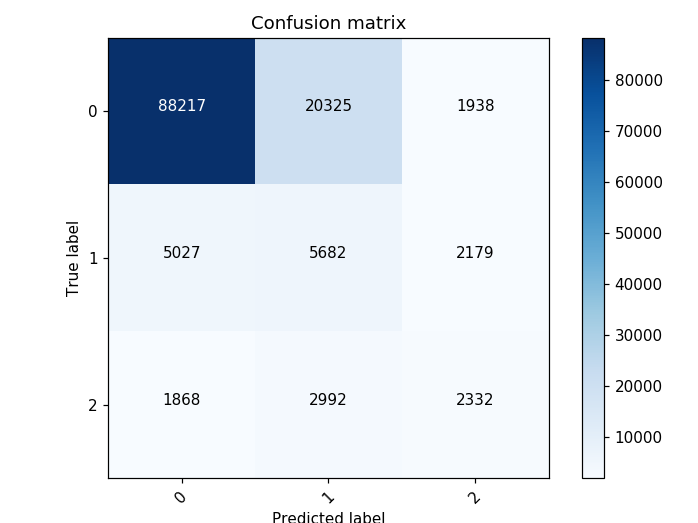

Confusion matrix, without normalization
[[88217 20325  1938]
 [ 5027  5682  2179]
 [ 1868  2992  2332]]


<IPython.core.display.Javascript object>


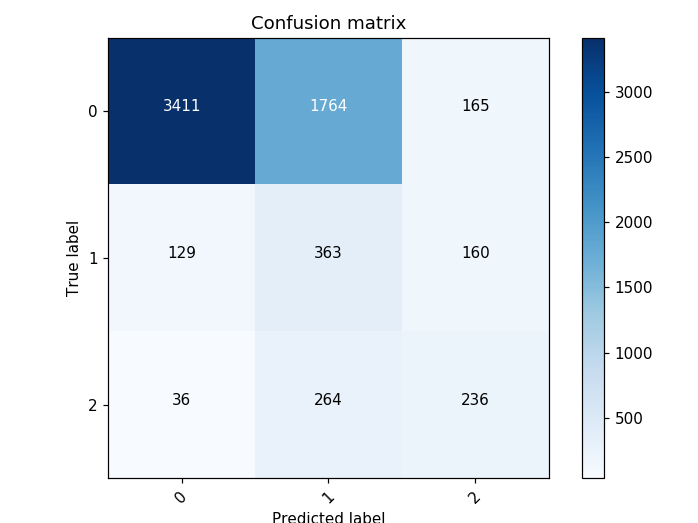

Confusion matrix, without normalization
[[3411 1764  165]
 [ 129  363  160]
 [  36  264  236]]


In [468]:
from sklearn.metrics import confusion_matrix,classification_report
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cm=confusion_matrix(Y_catagory_plot.ravel(),Y_predict.ravel())
plt.figure()
plot_confusion_matrix(cm, classes=['0','1','2'],
                      title='Confusion matrix')


cm_max=confusion_matrix(np.max(Y_catagory_plot,axis=1),np.max(Y_predict,axis=1))
plt.figure()
plot_confusion_matrix(cm_max, classes=['0','1','2'],
                      title='Confusion matrix')

In [444]:
from sklearn.metrics import confusion_matrix, classification_report
threshold = 0.5
print('---------classification report:  all values---------')

print(classification_report(Y_catagory_plot.ravel(), np.round(Y_predict.ravel()+0.5-threshold), target_names=['0','1','2']))

print('---------classification report:  maximum value---------')
print(classification_report(np.max(Y_catagory_plot,axis=1),np.max(Y_predict,axis=1), target_names=['0','1','2']))


---------classification report:  all values---------
             precision    recall  f1-score   support

          0       0.93      0.80      0.86    110480
          1       0.20      0.44      0.27     12888
          2       0.36      0.32      0.34      7192

avg / total       0.82      0.74      0.77    130560

---------classification report:  maximum value---------
             precision    recall  f1-score   support

          0       0.95      0.64      0.77      5340
          1       0.15      0.56      0.24       652
          2       0.42      0.44      0.43       536

avg / total       0.83      0.61      0.69      6528



### Cross-plotting data vs prediction 

<IPython.core.display.Javascript object>


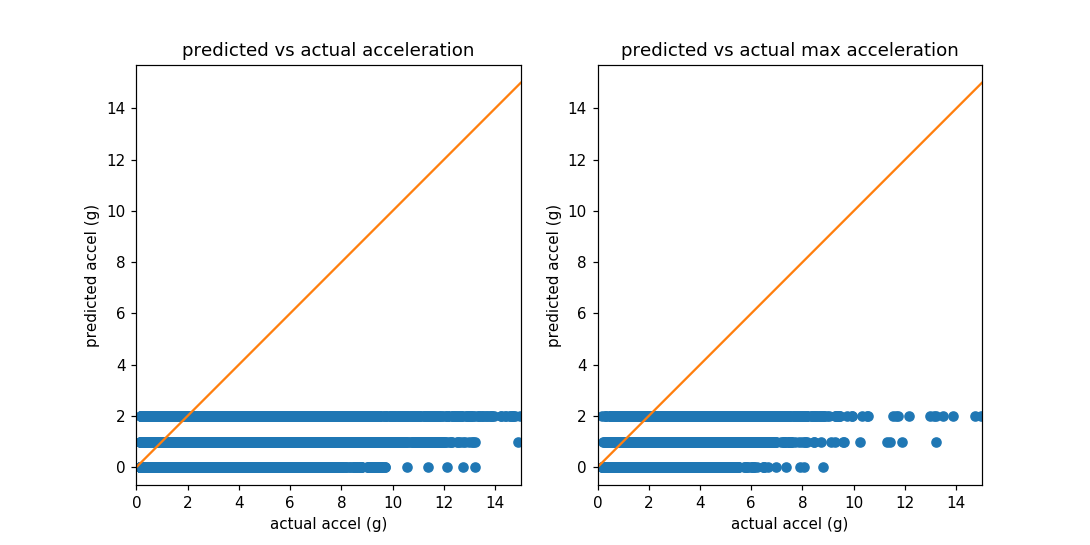

In [240]:
# Plotting statistics 
# accel0=10
plt.figure(figsize=[10,5])
ax1=plt.subplot(121)
plt.plot(Ys_plot.ravel(),Y_predict.ravel(),'o')
# plt.plot(accel0*Y_predict.ravel(),accel0*Ys_plot.ravel(),'o')

plt.plot([0,15],[0,15],'-')
plt.title('predicted vs actual acceleration')
plt.xlabel('actual accel (g)')
plt.ylabel('predicted accel (g)')
ax1.set_aspect('equal')
plt.xlim(0,15)
plt.ylim(0,15)
plt.show()

ax2=plt.subplot(122,sharex=ax1,sharey=ax1)
plt.plot(np.max(Ys_plot,axis=1),np.max(Y_predict,axis=1),'o')
plt.title('predicted vs actual max acceleration')
plt.xlabel('actual accel (g)')
plt.ylabel('predicted accel (g)')
ax2.set_aspect('equal')
plt.plot([0,15],[0,15],'-')
plt.xlim(0,15)
plt.ylim(0,15)
plt.show()

### Plot model prediction with Depth

In [95]:
np.mean((Ys_plot-Y_predict_test)**2)

0.88673015417349998

In [96]:
def r2Coeff(y_data,y_pred):
    ss_tot=np.sum((y_data-np.mean(y_data))**2)
    ss_res=np.sum((y_data-y_pred)**2)
    r2=1-ss_res/ss_tot
    return r2

In [97]:
# r2Coeff(Ys_train,Y_predict_train)
r2_train=r2Coeff(np.max(Ys_train,axis=1),np.max(Y_predict_train,axis=1))
r2_test=r2Coeff(np.max(Ys_test,axis=1),np.max(Y_predict_test,axis=1))

<IPython.core.display.Javascript object>


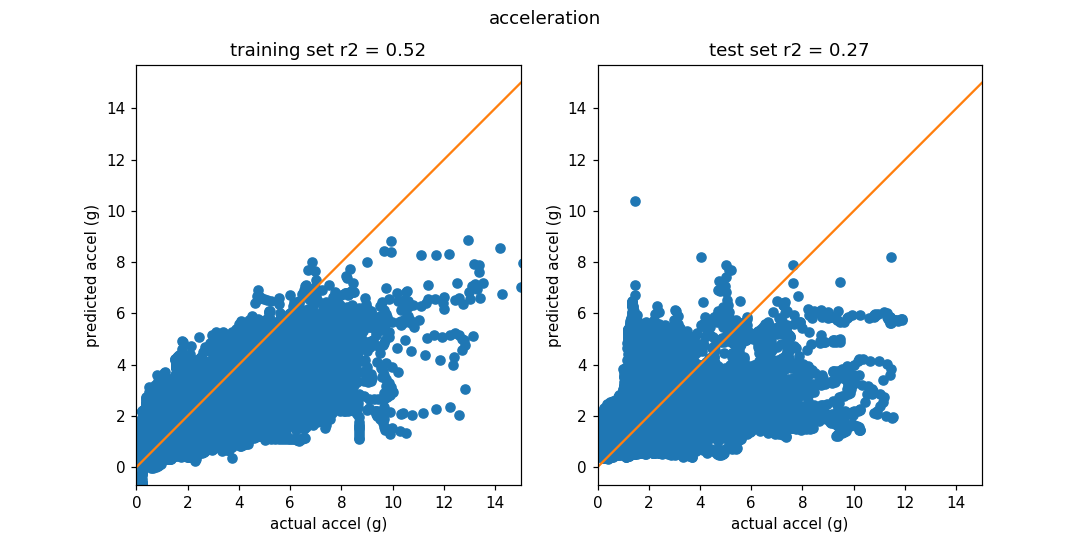

<IPython.core.display.Javascript object>


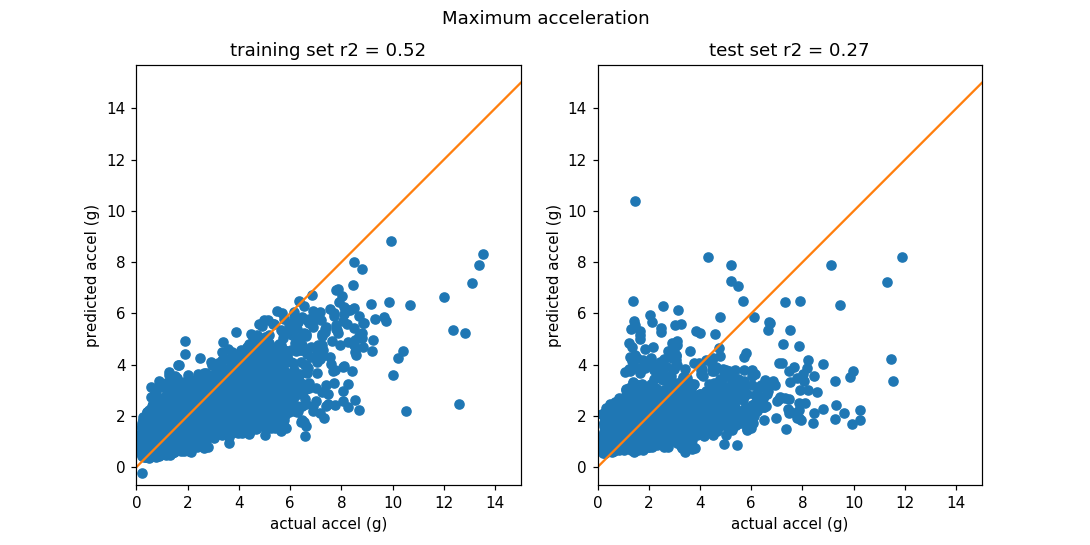

Text(0.5,0.98,'Maximum acceleration')

In [98]:
# Plotting statistics 
plt.figure(figsize=[10,5])
ax1=plt.subplot(121)
plt.plot(Ys_train.ravel(),Y_predict_train.ravel(),'o')
# plt.plot(accel0*Y_predict.ravel(),accel0*Ys_plot.ravel(),'o')

plt.plot([0,15],[0,15],'-')
plt.title('training set r2 = %2.2f'%r2_train)
plt.xlabel('actual accel (g)')
plt.ylabel('predicted accel (g)')
ax1.set_aspect('equal')
plt.xlim(0,15)
plt.ylim(0,15)
plt.show()

ax2=plt.subplot(122,sharex=ax1,sharey=ax1)
plt.plot(Ys_test.ravel(),Y_predict_test.ravel(),'o')
plt.title('test set r2 = %2.2f'%r2_test)
plt.xlabel('actual accel (g)')
plt.ylabel('predicted accel (g)')
ax2.set_aspect('equal')
plt.plot([0,15],[0,15],'-')
plt.xlim(0,15)
plt.ylim(0,15)
plt.show()
plt.suptitle('acceleration')

plt.figure(figsize=[10,5])
ax1=plt.subplot(121)
# plt.plot(accel0*Ys_train.ravel(),accel0*Y_predict_train.ravel(),'o')
plt.plot(np.max(Ys_train,axis=1),np.max(Y_predict_train,axis=1),'o')

plt.plot([0,15],[0,15],'-')
plt.title('training set r2 = %2.2f'%r2_train)
plt.xlabel('actual accel (g)')
plt.ylabel('predicted accel (g)')
ax1.set_aspect('equal')
plt.xlim(0,15)
plt.ylim(0,15)
plt.show()

ax2=plt.subplot(122,sharex=ax1,sharey=ax1)
plt.plot(np.max(Ys_test,axis=1),np.max(Y_predict_test,axis=1),'o')
plt.title('test set r2 = %2.2f'%r2_test)
plt.xlabel('actual accel (g)')
plt.ylabel('predicted accel (g)')
ax2.set_aspect('equal')
plt.plot([0,15],[0,15],'-')
plt.xlim(0,15)
plt.ylim(0,15)
plt.show()
plt.suptitle('Maximum acceleration')

### Plot with depth

<IPython.core.display.Javascript object>


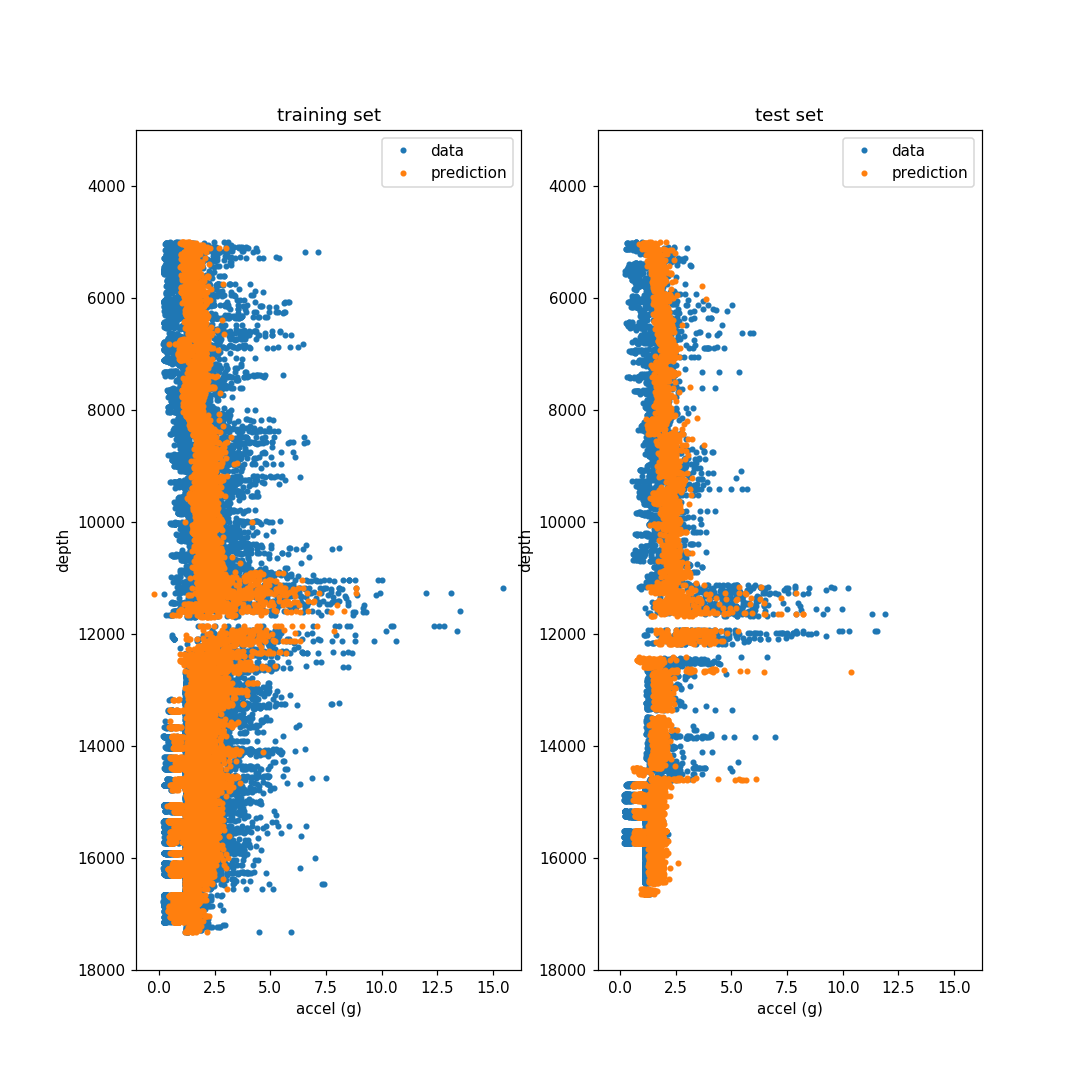

<IPython.core.display.Javascript object>


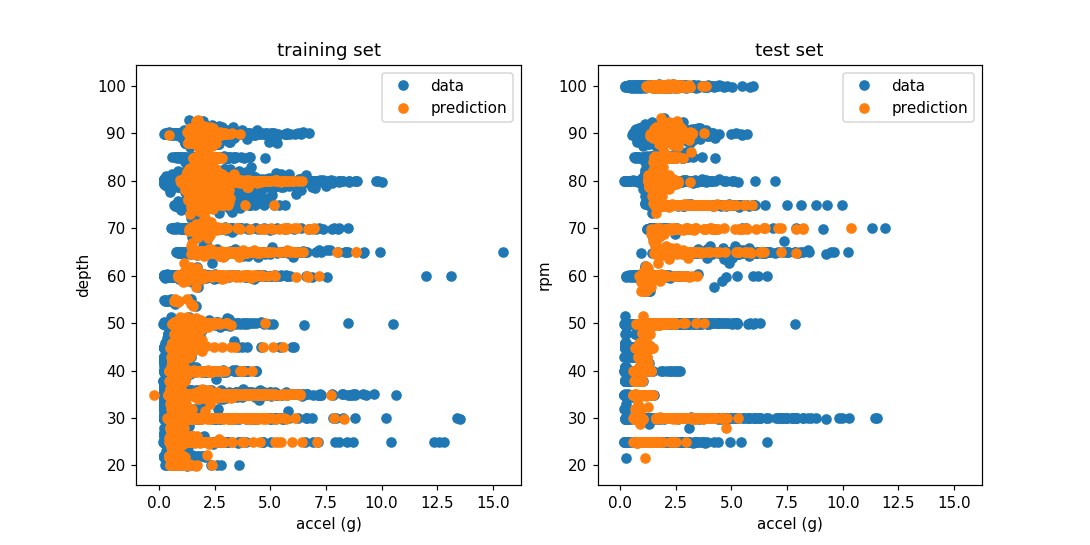

In [99]:
depth_train=auxDataDict_train['01_Global-Generic_Surface-BIT_DEPTH']
depth_test=auxDataDict_test['01_Global-Generic_Surface-BIT_DEPTH']

rpm_train=auxDataDict_train['01_Global-Generic_Surface-SRPM']
rpm_test=auxDataDict_test['01_Global-Generic_Surface-SRPM']
plt.figure(figsize=[10,10])
ax1=plt.subplot(121)
# plt.plot(np.max(accel0*Y_predict_test,axis=1),depth_test,'o',label='validation')
plt.plot(np.max(Ys_train,axis=1),depth_train*3.28,'.',label='data')
plt.plot(np.max(Y_predict_train,axis=1),depth_train*3.28,'.',label='prediction')
# plt.gca().invert_yaxis()
plt.title('training set')
plt.xlabel('accel (g)')
plt.ylabel('depth')
plt.xlim(0,15)
plt.ylim(18000,3000)
plt.show()
plt.legend()

ax2=plt.subplot(122,sharex=ax1,sharey=ax1)
plt.plot(np.max(Ys_test,axis=1),depth_test*3.28,'.',label='data')
plt.plot(np.max(Y_predict_test,axis=1),depth_test*3.28,'.',label='prediction')

plt.title('test set')
plt.xlabel('accel (g)')
plt.ylabel('depth')
# plt.xlim(0,15)
plt.ylim(18000,3000)
plt.legend()
plt.show()

plt.figure(figsize=[10,5])
ax1=plt.subplot(121)
# plt.plot(np.max(accel0*Y_predict_test,axis=1),depth_test,'o',label='validation')
plt.plot(np.max(Ys_train,axis=1),rpm_train,'o',label='data')
plt.plot(np.max(Y_predict_train,axis=1),rpm_train,'o',label='prediction')

plt.title('training set')
plt.xlabel('accel (g)')
plt.ylabel('depth')
plt.xlim(0,15)
# plt.ylim(0,15)
plt.show()
plt.legend()

ax2=plt.subplot(122,sharex=ax1,sharey=ax1)
plt.plot(np.max(Ys_test,axis=1),rpm_test,'o',label='data')
plt.plot(np.max(Y_predict_test,axis=1),rpm_test,'o',label='prediction')

plt.title('test set')
plt.xlabel('accel (g)')
plt.ylabel('rpm')
# plt.xlim(0,15)
# plt.ylim(0,15)
plt.legend()
plt.show()

### Save model

In [347]:
imodel=np.argmin([score[0] for score in scoreList])
#imodel=np.argmax([score[2] for score in scoreList])

model=modelList[imodel]
param=ParamList[imodel]
# model_name = 'regression_8channel_30s_50Hz_separateData.h5'
model_name = 'models/regression_8channel_30s_all_rpm'+str(freqMax)+'Hz_separateData_nlstm='+str(param[0])+'_dropout='+str(param[1])
# model.save(model_name)

# Save as Json and weights
# Save model
json_name=model_name+'.json'
model_json = model.to_json()
with open(json_name, "w") as json_file:
    json_file.write(model_json)
model.save_weights(model_name+'.h5')